# Super Resolution 에 필요한 모듈 설치 & 정의
- timm
- SwinIR

In [ ]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 6.9 MB/s 


## SwinIR

In [ ]:
# -----------------------------------------------------------------------------------
# SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# Originally Written by Ze Liu, Modified by Jingyun Liang.
# -----------------------------------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops

# 이거 사용
# PatchEmbed, RSTB
class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops


if __name__ == '__main__':
    upscale = 4
    window_size = 8
    height = (1024 // upscale // window_size + 1) * window_size
    width = (720 // upscale // window_size + 1) * window_size
    model = SwinIR(upscale=2, img_size=(height, width),
                   window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                   embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')
    print(model)
    print(height, width, model.flops() / 1e9)

    x = torch.randn((1, 3, height, width))
    x = model(x)
    print(x.shape)


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinIR(
  (conv_first): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(264, 184), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(264, 184), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=60, window_size=(8, 8), num_heads=6
              (qkv): Linear(in_features=60, out_features=180, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=60, out_features=60, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
            

## 함수화

In [ ]:
import cv2
import numpy as np

# model_path = '/content/drive/MyDrive/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth'

def sr(image, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), scale = 4, model_path = None):

    if model_path is None:
      
      url = "https://drive.google.com/uc?id=1d1RwNhiyxVu7zkNcIReifcyg5wkVc-xv"
      output = "003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth"

      if not os.path.exists('/content/'+output):
        
        model_path = gdown.download(url, output, quiet=False)
      model_path = '/content/'+output
      
        
    else:
      model_path = model_path

    img_lq = image.astype(np.float32) / 255.
    img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
    img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device)  # CHW-RGB to NCHW-RGB

    
    
    model = SwinIR(upscale=scale, in_chans=3, img_size=64, window_size=8,
                            img_range=1., depths=[6, 6, 6, 6, 6, 6, 6, 6, 6], embed_dim=240,
                            num_heads=[8, 8, 8, 8, 8, 8, 8, 8, 8],
                            mlp_ratio=2, upsampler='nearest+conv', resi_connection='3conv')
    param_key_g = 'params_ema'

    pretrained_model = torch.load(model_path)
    model.load_state_dict(pretrained_model[param_key_g] if param_key_g in pretrained_model.keys() else pretrained_model, strict=True)

    model.eval()
    model = model.to(device)

    with torch.no_grad():
        # pad input image to be a multiple of window_size
        _, _, h_old, w_old = img_lq.size()
        h_pad = (h_old // window_size + 1) * window_size - h_old
        w_pad = (w_old // window_size + 1) * window_size - w_old
        img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
        img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
        output = model(img_lq)   # test로 예측한다 -> 살펴보기( ) -> tile이 None일때(기본값) 이렇게 예측
        output = output[..., :h_old * scale, :w_old * scale]

    # save image
    output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
    if output.ndim == 3:
        output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # CHW-RGB to HCW-BGR
    output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8

    return output

# Recognition 에 필요한 모듈 설치 & 정의

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TPS_SpatialTransformerNetwork(nn.Module):
    """ Rectification Network of RARE, namely TPS based STN """

    def __init__(self, F, I_size, I_r_size, I_channel_num=1):
        """ Based on RARE TPS
        input:
            batch_I: Batch Input Image [batch_size x I_channel_num x I_height x I_width]
            I_size : (height, width) of the input image I
            I_r_size : (height, width) of the rectified image I_r
            I_channel_num : the number of channels of the input image I
        output:
            batch_I_r: rectified image [batch_size x I_channel_num x I_r_height x I_r_width]
        """
        super(TPS_SpatialTransformerNetwork, self).__init__()
        self.F = F
        self.I_size = I_size
        self.I_r_size = I_r_size  # = (I_r_height, I_r_width)
        self.I_channel_num = I_channel_num
        self.LocalizationNetwork = LocalizationNetwork(self.F, self.I_channel_num)
        self.GridGenerator = GridGenerator(self.F, self.I_r_size)

    def forward(self, batch_I):
        batch_C_prime = self.LocalizationNetwork(batch_I)  # batch_size x K x 2
        build_P_prime = self.GridGenerator.build_P_prime(batch_C_prime)  # batch_size x n (= I_r_width x I_r_height) x 2
        build_P_prime_reshape = build_P_prime.reshape([build_P_prime.size(0), self.I_r_size[0], self.I_r_size[1], 2])
        
        if torch.__version__ > "1.2.0":
            batch_I_r = F.grid_sample(batch_I, build_P_prime_reshape, padding_mode='border', align_corners=True)
        else:
            batch_I_r = F.grid_sample(batch_I, build_P_prime_reshape, padding_mode='border')

        return batch_I_r


class LocalizationNetwork(nn.Module):
    """ Localization Network of RARE, which predicts C' (K x 2) from I (I_width x I_height) """

    def __init__(self, F, I_channel_num):
        super(LocalizationNetwork, self).__init__()
        self.F = F
        self.I_channel_num = I_channel_num
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.I_channel_num, out_channels=64, kernel_size=3, stride=1, padding=1,
                      bias=False), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 64 x I_height/2 x I_width/2
            nn.Conv2d(64, 128, 3, 1, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 128 x I_height/4 x I_width/4
            nn.Conv2d(128, 256, 3, 1, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.MaxPool2d(2, 2),  # batch_size x 256 x I_height/8 x I_width/8
            nn.Conv2d(256, 512, 3, 1, 1, bias=False), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1)  # batch_size x 512
        )

        self.localization_fc1 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(True))
        self.localization_fc2 = nn.Linear(256, self.F * 2)

        # Init fc2 in LocalizationNetwork
        self.localization_fc2.weight.data.fill_(0)
        """ see RARE paper Fig. 6 (a) """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = np.linspace(0.0, -1.0, num=int(F / 2))
        ctrl_pts_y_bottom = np.linspace(1.0, 0.0, num=int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        initial_bias = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        self.localization_fc2.bias.data = torch.from_numpy(initial_bias).float().view(-1)

    def forward(self, batch_I):
        """
        input:     batch_I : Batch Input Image [batch_size x I_channel_num x I_height x I_width]
        output:    batch_C_prime : Predicted coordinates of fiducial points for input batch [batch_size x F x 2]
        """
        batch_size = batch_I.size(0)
        features = self.conv(batch_I).view(batch_size, -1)
        batch_C_prime = self.localization_fc2(self.localization_fc1(features)).view(batch_size, self.F, 2)
        return batch_C_prime


class GridGenerator(nn.Module):
    """ Grid Generator of RARE, which produces P_prime by multipling T with P """

    def __init__(self, F, I_r_size):
        """ Generate P_hat and inv_delta_C for later """
        super(GridGenerator, self).__init__()
        self.eps = 1e-6
        self.I_r_height, self.I_r_width = I_r_size
        self.F = F
        self.C = self._build_C(self.F)  # F x 2
        self.P = self._build_P(self.I_r_width, self.I_r_height)
        ## for multi-gpu, you need register buffer
        self.register_buffer("inv_delta_C", torch.tensor(self._build_inv_delta_C(self.F, self.C)).float())  # F+3 x F+3
        self.register_buffer("P_hat", torch.tensor(self._build_P_hat(self.F, self.C, self.P)).float())  # n x F+3
        ## for fine-tuning with different image width, you may use below instead of self.register_buffer
        #self.inv_delta_C = torch.tensor(self._build_inv_delta_C(self.F, self.C)).float().cuda()  # F+3 x F+3
        #self.P_hat = torch.tensor(self._build_P_hat(self.F, self.C, self.P)).float().cuda()  # n x F+3

    def _build_C(self, F):
        """ Return coordinates of fiducial points in I_r; C """
        ctrl_pts_x = np.linspace(-1.0, 1.0, int(F / 2))
        ctrl_pts_y_top = -1 * np.ones(int(F / 2))
        ctrl_pts_y_bottom = np.ones(int(F / 2))
        ctrl_pts_top = np.stack([ctrl_pts_x, ctrl_pts_y_top], axis=1)
        ctrl_pts_bottom = np.stack([ctrl_pts_x, ctrl_pts_y_bottom], axis=1)
        C = np.concatenate([ctrl_pts_top, ctrl_pts_bottom], axis=0)
        return C  # F x 2

    def _build_inv_delta_C(self, F, C):
        """ Return inv_delta_C which is needed to calculate T """
        hat_C = np.zeros((F, F), dtype=float)  # F x F
        for i in range(0, F):
            for j in range(i, F):
                r = np.linalg.norm(C[i] - C[j])
                hat_C[i, j] = r
                hat_C[j, i] = r
        np.fill_diagonal(hat_C, 1)
        hat_C = (hat_C ** 2) * np.log(hat_C)
        # print(C.shape, hat_C.shape)
        delta_C = np.concatenate(  # F+3 x F+3
            [
                np.concatenate([np.ones((F, 1)), C, hat_C], axis=1),  # F x F+3
                np.concatenate([np.zeros((2, 3)), np.transpose(C)], axis=1),  # 2 x F+3
                np.concatenate([np.zeros((1, 3)), np.ones((1, F))], axis=1)  # 1 x F+3
            ],
            axis=0
        )
        inv_delta_C = np.linalg.inv(delta_C)
        return inv_delta_C  # F+3 x F+3

    def _build_P(self, I_r_width, I_r_height):
        I_r_grid_x = (np.arange(-I_r_width, I_r_width, 2) + 1.0) / I_r_width  # self.I_r_width
        I_r_grid_y = (np.arange(-I_r_height, I_r_height, 2) + 1.0) / I_r_height  # self.I_r_height
        P = np.stack(  # self.I_r_width x self.I_r_height x 2
            np.meshgrid(I_r_grid_x, I_r_grid_y),
            axis=2
        )
        return P.reshape([-1, 2])  # n (= self.I_r_width x self.I_r_height) x 2

    def _build_P_hat(self, F, C, P):
        n = P.shape[0]  # n (= self.I_r_width x self.I_r_height)
        P_tile = np.tile(np.expand_dims(P, axis=1), (1, F, 1))  # n x 2 -> n x 1 x 2 -> n x F x 2
        C_tile = np.expand_dims(C, axis=0)  # 1 x F x 2
        P_diff = P_tile - C_tile  # n x F x 2
        rbf_norm = np.linalg.norm(P_diff, ord=2, axis=2, keepdims=False)  # n x F
        rbf = np.multiply(np.square(rbf_norm), np.log(rbf_norm + self.eps))  # n x F
        P_hat = np.concatenate([np.ones((n, 1)), P, rbf], axis=1)
        return P_hat  # n x F+3

    def build_P_prime(self, batch_C_prime):
        """ Generate Grid from batch_C_prime [batch_size x F x 2] """
        batch_size = batch_C_prime.size(0)
        batch_inv_delta_C = self.inv_delta_C.repeat(batch_size, 1, 1)
        batch_P_hat = self.P_hat.repeat(batch_size, 1, 1)
        batch_C_prime_with_zeros = torch.cat((batch_C_prime, torch.zeros(
            batch_size, 3, 2).float().to(device)), dim=1)  # batch_size x F+3 x 2
        batch_T = torch.bmm(batch_inv_delta_C, batch_C_prime_with_zeros)  # batch_size x F+3 x 2
        batch_P_prime = torch.bmm(batch_P_hat, batch_T)  # batch_size x n x 2
        return batch_P_prime  # batch_size x n x 2


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = self._conv3x3(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = self._conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def _conv3x3(self, in_planes, out_planes, stride=1):
        "3x3 convolution with padding"
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                         padding=1, bias=False)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, input_channel, output_channel, block, layers):
        super(ResNet, self).__init__()

        self.output_channel_block = [int(output_channel / 4), int(output_channel / 2), output_channel, output_channel]

        self.inplanes = int(output_channel / 8)
        self.conv0_1 = nn.Conv2d(input_channel, int(output_channel / 16),
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_1 = nn.BatchNorm2d(int(output_channel / 16))
        self.conv0_2 = nn.Conv2d(int(output_channel / 16), self.inplanes,
                                 kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0_2 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer1 = self._make_layer(block, self.output_channel_block[0], layers[0])
        self.conv1 = nn.Conv2d(self.output_channel_block[0], self.output_channel_block[
                               0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.output_channel_block[0])

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.layer2 = self._make_layer(block, self.output_channel_block[1], layers[1], stride=1)
        self.conv2 = nn.Conv2d(self.output_channel_block[1], self.output_channel_block[
                               1], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.output_channel_block[1])

        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=(2, 1), padding=(0, 1))
        self.layer3 = self._make_layer(block, self.output_channel_block[2], layers[2], stride=1)
        self.conv3 = nn.Conv2d(self.output_channel_block[2], self.output_channel_block[
                               2], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.output_channel_block[2])

        self.layer4 = self._make_layer(block, self.output_channel_block[3], layers[3], stride=1)
        self.conv4_1 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=(2, 1), padding=(0, 1), bias=False)
        self.bn4_1 = nn.BatchNorm2d(self.output_channel_block[3])
        self.conv4_2 = nn.Conv2d(self.output_channel_block[3], self.output_channel_block[
                                 3], kernel_size=2, stride=1, padding=0, bias=False)
        self.bn4_2 = nn.BatchNorm2d(self.output_channel_block[3])

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0_1(x)
        x = self.bn0_1(x)
        x = self.relu(x)
        x = self.conv0_2(x)
        x = self.bn0_2(x)
        x = self.relu(x)

        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.maxpool3(x)
        x = self.layer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)

        return x


In [ ]:
class ResNet_FeatureExtractor(nn.Module):
    """ FeatureExtractor of FAN (http://openaccess.thecvf.com/content_ICCV_2017/papers/Cheng_Focusing_Attention_Towards_ICCV_2017_paper.pdf) """

    def __init__(self, input_channel, output_channel=512):
        super(ResNet_FeatureExtractor, self).__init__()
        self.ConvNet = ResNet(input_channel, output_channel, BasicBlock, [1, 2, 5, 3])

    def forward(self, input):
        return self.ConvNet(input)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CTCLabelConverter(object):
    """ Convert between text-label and text-index """

    def __init__(self, character):
        # character (str): set of the possible characters.
        dict_character = list(character)

        self.dict = {}
        for i, char in enumerate(dict_character):
            # NOTE: 0 is reserved for 'CTCblank' token required by CTCLoss
            self.dict[char] = i + 1

        self.character = ['[CTCblank]'] + dict_character  # dummy '[CTCblank]' token for CTCLoss (index 0)

    def encode(self, text, batch_max_length=25):
        """convert text-label into text-index.
        input:
            text: text labels of each image. [batch_size]
            batch_max_length: max length of text label in the batch. 25 by default

        output:
            text: text index for CTCLoss. [batch_size, batch_max_length]
            length: length of each text. [batch_size]
        """
        length = [len(s) for s in text]

        # The index used for padding (=0) would not affect the CTC loss calculation.
        batch_text = torch.LongTensor(len(text), batch_max_length).fill_(0)
        for i, t in enumerate(text):
            text = list(t)
            text = [self.dict[char] for char in text]
            batch_text[i][:len(text)] = torch.LongTensor(text)
        return (batch_text.to(device), torch.IntTensor(length).to(device))

    def decode(self, text_index, length):
        """ convert text-index into text-label. """
        texts = []
        for index, l in enumerate(length):
            t = text_index[index, :]

            char_list = []
            for i in range(l):
                if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                    char_list.append(self.character[t[i]])
            text = ''.join(char_list)

            texts.append(text)
        return texts

In [ ]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

In [ ]:
# from modules.transformation import TPS_SpatialTransformerNetwork
# from modules.feature_extraction import VGG_FeatureExtractor, RCNN_FeatureExtractor, ResNet_FeatureExtractor
# from modules.sequence_modeling import BidirectionalLSTM
# from modules.prediction import Attention


class Model(nn.Module):

    def __init__(self, Transformation='TPS', FeatureExtraction='ResNet', SequenceModeling='BiLSTM', Prediction='CTC', num_fiducial = 20, imgH = 64, imgW = 200,
                 input_channel = 1, output_channel = 512, hidden_size = 256, num_class = 1011):
        super(Model, self).__init__()
        self.Transformation = Transformation
        self.FeatureExtraction = FeatureExtraction
        self.SequenceModeling = SequenceModeling
        self.Prediction = Prediction

        self.num_fiducial = num_fiducial
        self.imgH = imgH
        self.imgW = imgW
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.hidden_size = hidden_size
        self.num_class = num_class

        self.stages = {'Trans': self.Transformation, 'Feat': self.FeatureExtraction,
                       'Seq': self.SequenceModeling, 'Pred': self.Prediction}

        """ Transformation """
        if self.Transformation == 'TPS':
            self.Transformation = TPS_SpatialTransformerNetwork(
                F=self.num_fiducial, I_size=(self.imgH, self.imgW), I_r_size=(self.imgH, self.imgW), I_channel_num=self.input_channel)
        else:
            print('No Transformation module specified')

        # Trannsformation으로 TPS 사용

        """ FeatureExtraction """
        if self.FeatureExtraction == 'VGG':
            self.FeatureExtraction = VGG_FeatureExtractor(self.input_channel, self.output_channel)
        elif self.FeatureExtraction == 'RCNN':
            self.FeatureExtraction = RCNN_FeatureExtractor(self.input_channel, self.output_channel)
        elif self.FeatureExtraction == 'ResNet':
            self.FeatureExtraction = ResNet_FeatureExtractor(self.input_channel, self.output_channel)
        else:
            raise Exception('No FeatureExtraction module specified')
        self.FeatureExtraction_output = self.output_channel  # int(imgH/16-1) * 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))  # Transform final (imgH/16-1) -> 1

        # FeatureExtraction으로 ResNet 사용, RCNN_FeatureExtractor함수를 사용한다. input_channe과 output_channel이 변수로 들어감

        """ Sequence modeling"""
        if self.SequenceModeling == 'BiLSTM':
            self.SequenceModeling = nn.Sequential(
                BidirectionalLSTM(self.FeatureExtraction_output, self.hidden_size, self.hidden_size),
                BidirectionalLSTM(self.hidden_size, self.hidden_size, self.hidden_size))
            self.SequenceModeling_output = self.hidden_size
        else:
            print('No SequenceModeling module specified')
            self.SequenceModeling_output = self.FeatureExtraction_output

        """ Prediction """
        if self.Prediction == 'CTC':
            self.Prediction = nn.Linear(self.SequenceModeling_output, self.num_class)
        elif self.Prediction == 'Attn':
            self.Prediction = Attention(self.SequenceModeling_output, self.hidden_size, self.num_class)
        else:
            raise Exception('Prediction is neither CTC or Attn')

        
        # 여기까지 TPS - ResNet - BiLSTM - CTC 사용에 따른 model을 설정해주는 과정

    def forward(self, input, text, is_train=True):
        """ Transformation stage """
        if not self.stages['Trans'] == "None":
            input = self.Transformation(input)

        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        if self.stages['Seq'] == 'BiLSTM':
            contextual_feature = self.SequenceModeling(visual_feature) # 위에서 설정해준 객체
        else:
            contextual_feature = visual_feature  # for convenience. this is NOT contextually modeled by BiLSTM

        """ Prediction stage """
        if self.stages['Pred'] == 'CTC':
            prediction = self.Prediction(contextual_feature.contiguous()) # 위에서 설정해준 객체
        # else:
        #     prediction = self.Prediction(contextual_feature.contiguous(), text, is_train, batch_max_length=self.opt.batch_max_length)

        return prediction  

        # 최종값으로 prediction 리턴해줌
        # input으로 image, text로 text_for_pred가 들어감, preds = model(image, text_for_pred)
        # text는 CTC 아닌경우에 들어가므로 필요 없을듯?

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
class ResizeNormalize(object):

    def __init__(self, size, interpolation=Image.BICUBIC):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img

## 함수화

In [ ]:
from PIL import Image
import torch.nn as nn
import numpy as np
import torch
import torch.nn.functional as F


# saved_model = '/content/drive/MyDrive/OCR/TPS-ResNet-BiLSTM-CTC-Seed1111/OrgandAug/100000it/best_norm_ED.pth' # 이거 어떻게 할건지, url, down 이용하는 방법?
# character = '0123456789abcdefghijklmnopqrstuvwxyz가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘?!'

def itt(image, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 
                saved_model = None, batch_max_length = 25, batch_size = 1, character = character, imgW = 200, imgH = 64):

    if saved_model is None:
      
      url = "https://drive.google.com/uc?id=1-YU62Q-yIap3yg6u7CCulP58fLS0QdZR"
      output = "best_norm_ED.pth"

      if not os.path.exists('/content/'+output):
        
        saved_model = gdown.download(url, output, quiet=False)
      saved_model = '/content/'+output
      
        
    else:
      saved_model = saved_model

    image=Image.fromarray(image)
    transform = ResizeNormalize((imgW, imgH)) #imgW, imgH 가 size라는 변수로 들어감
    image_tensors = transform(image)
    image_tensors = image_tensors.reshape(-1, 1, imgH, imgW)

    model = Model()
    model = torch.nn.DataParallel(model).to(device)

    model.load_state_dict(torch.load(saved_model, map_location=device))
    model.eval()

    character = '0123456789abcdefghijklmnopqrstuvwxyz가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘?!'

    converter = CTCLabelConverter(character)

    with torch.no_grad():
        image = image_tensors.to(device)
        text_for_pred = torch.LongTensor(batch_size, batch_max_length + 1).fill_(0).to(device)

        preds = model(image, text_for_pred)
        preds_size = torch.IntTensor([preds.size(1)] * batch_size)
        _, preds_index = preds.max(2)
        # preds_index = preds_index.view(-1)
        preds_str = converter.decode(preds_index, preds_size)   
    
    return preds_str

# Detection-SR-Recognition

In [ ]:
import cv2
import torch
from PIL import Image

def yolov5s_detect(img, save_path = None) :
    # !gdown --id 10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw
    # path = '/content/best.pt'
    # model = torch.hub.load('ultralytics/yolov5', 'custom', path=path)

    if save_path is None:
      
      url = "https://drive.google.com/uc?id=10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw"
      output = "best.pt"

      if not os.path.exists('/content/'+output):
        
        save_path = gdown.download(url, output, quiet=False)
      save_path = '/content/'+output
      
    else:
      save_path = save_path

    model = torch.hub.load('ultralytics/yolov5', 'custom', path=save_path)


    data_img = img

    results = model(data_img)
    print('탐지된 이미지의 수 : ',len(results.xyxy[0]))
    
    crop_images = []
    for idx in range(len(results.xyxy[0])) :

        xy = results.xyxy[0][idx].cpu().numpy()

        start = (int(xy[1]),int(xy[0])) # y, x좌표 min값
        end = (int(xy[3]),int(xy[2])) # y, x좌표 max값

        output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
        # print(output.shape)

        for y in range(output.shape[1]):
            for x in range(output.shape[0]):
                xp, yp = x + start[0], y+start[1]
                output[x,y] = img[xp,yp]

        # crop image
        crop_image = np.asarray(output)
 
        crop_images.append(crop_image)
  
        
    return crop_images, results.xyxy[0]

# 이미지 위에 text 쓰기 
- 원본 이미지의 bbox좌표에 text 넣기

In [ ]:
import os

# model_path = '/content/drive/MyDrive/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth'
# saved_model = '/content/drive/MyDrive/OCR/TPS-ResNet-BiLSTM-CTC-Seed1111/OrgandAug/100000it/best_norm_ED.pth' # 이거 어떻게 할건지, url, down 이용하는 방법?
# character = '0123456789abcdefghijklmnopqrstuvwxyz가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘?!'

for file_name in os.listdir('/content/test'):
    img = cv2.imread('/content/test/'+file_name)
    crop_images, bboxs = yolov5s_detect(img)

    texts = []
    for crop_image in crop_images:
        sr_img = sr(crop_image)
        text = itt(sr_img)
        texts.append(text)

    print(texts)




/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw
To: /content/best.pt
100% 14.8M/14.8M [00:00<00:00, 173MB/s]


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-7-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


탐지된 이미지의 수 :  2
tensor([[159.99484,  44.88322, 198.75583,  60.17443,   0.76253,   0.00000],
        [113.58392,  44.31783, 150.74527,  60.11415,   0.74708,   0.00000]], device='cuda:0')
[['사진관'], ['여기에']]


In [ ]:
from PIL import Image, ImageDraw,ImageFilter, ImageFont
import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np

"""
tensor([[159.99484,  44.88322, 198.75583,  60.17443,   0.76253,   0.00000],
        [113.58392,  44.31783, 150.74527,  60.11415,   0.74708,   0.00000]], device='cuda:0')"""


def img_blur_text(image, bboxs, texts, mag=30, font_down = None):
  
    if font_down is None:
      
      url = "https://drive.google.com/uc?id=17IK1YuODQxjJDQtVEqOF22EtvDh37wUs"
      output = "best.pt"

      if not os.path.exists('/content/'+output):
        
        font_down = gdown.download(url, output, quiet=False)
      font_down = '/content/'+output
      
    else:
      font_down = font_down


    #   img = Image.open(image).convert('RGB')
    #   blurI = img.filter(ImageFilter.GaussianBlur(50))

    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  
    
    for bbox, text in zip(bboxs, texts):
        x = int(bbox[0])
        y = int(bbox[1])
        x_ = int(bbox[2])
        y_ = int(bbox[3])

        roi = img[y:y_, x:x_]
        roi = cv2.blur(roi, (mag, mag))
        img[y:y_, x:x_] = roi

        img_p = Image.fromarray(img)

        text_size = int((bbox[3]-bbox[1])*0.9)

        # 글자 위치
        xs, ys = int(x*1.02), int(y*1.02)
        text_pos = (xs, ys)

        # 글자 타입 ( 글자 폰트, 글자 크기)
        font_type = ImageFont.truetype('/content/NanumBarunGothic.ttf',text_size)
    
        # 글자색
        color = (0,0,0)

        draw = ImageDraw.Draw(img_p)

        draw.text(text_pos, text[0], color, font=font_type)
        
        img = np.array(img_p) 
        # 텍스트가 쓰여진 이미지를 다시 배열로 바꿔서 for문을 돌 수 있게 사용

    return img

    

  


테스트

Downloading...
From: https://drive.google.com/uc?id=17IK1YuODQxjJDQtVEqOF22EtvDh37wUs
To: /content/NanumBarunGothic.ttf
100%|██████████| 4.19M/4.19M [00:00<00:00, 71.8MB/s]


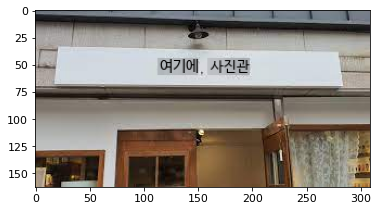

In [ ]:
img_path = '/content/test/1.jpg'
texts = [['사진관'], ['여기에']]
bboxs = [[159.99484,  44.88322, 198.75583,  60.17443,   0.76253,   0.00000],
         [113.58392,  44.31783, 150.74527,  60.11415,   0.74708,   0.00000]]
image = cv2.imread(img_path)
img = img_blur_text(image=image, bboxs=bboxs, texts=texts)
plt.imshow(img)


# Detection - SR - Recognition - drawtext

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw
To: /content/best.pt
100% 14.8M/14.8M [00:00<00:00, 218MB/s]


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


탐지된 이미지의 수 :  2


Downloading...
From: https://drive.google.com/uc?id=17IK1YuODQxjJDQtVEqOF22EtvDh37wUs
To: /content/NanumBarunGothic.ttf
100%|██████████| 4.19M/4.19M [00:00<00:00, 197MB/s]


[['사진관'], ['여기에']]


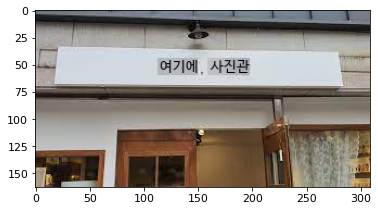

In [ ]:
import os

model_path = '/content/drive/MyDrive/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth'
saved_model = '/content/drive/MyDrive/OCR/TPS-ResNet-BiLSTM-CTC-Seed1111/OrgandAug/100000it/best_norm_ED.pth' # 이거 어떻게 할건지, url, down 이용하는 방법?
character = '0123456789abcdefghijklmnopqrstuvwxyz가각간갇갈감갑값갓강갖같갚갛개객걀걔거걱건걷걸검겁것겉게겨격겪견결겹경곁계고곡곤곧골곰곱곳공과관광괜괴굉교구국군굳굴굵굶굽궁권귀귓규균귤그극근글긁금급긋긍기긴길김깅깊까깍깎깐깔깜깝깡깥깨꺼꺾껌껍껏껑께껴꼬꼭꼴꼼꼽꽂꽃꽉꽤꾸꾼꿀꿈뀌끄끈끊끌끓끔끗끝끼낌나낙낚난날낡남납낫낭낮낯낱낳내냄냇냉냐냥너넉넌널넓넘넣네넥넷녀녁년념녕노녹논놀놈농높놓놔뇌뇨누눈눕뉘뉴늄느늑는늘늙능늦늬니닐님다닥닦단닫달닭닮담답닷당닿대댁댐댓더덕던덜덟덤덥덧덩덮데델도독돈돌돕돗동돼되된두둑둘둠둡둥뒤뒷드득든듣들듬듭듯등디딩딪따딱딴딸땀땅때땜떠떡떤떨떻떼또똑뚜뚫뚱뛰뜨뜩뜯뜰뜻띄라락란람랍랑랗래랜램랫략량러럭런럴럼럽럿렁렇레렉렌려력련렬렵령례로록론롬롭롯료루룩룹룻뤄류륙률륭르른름릇릎리릭린림립릿링마막만많말맑맘맙맛망맞맡맣매맥맨맵맺머먹먼멀멈멋멍멎메멘멩며면멸명몇모목몬몰몸몹못몽묘무묵묶문묻물뭄뭇뭐뭘뭣므미민믿밀밉밌및밑바박밖반받발밝밟밤밥방밭배백뱀뱃뱉버번벌범법벗베벤벨벼벽변별볍병볕보복볶본볼봄봇봉뵈뵙부북분불붉붐붓붕붙뷰브븐블비빌빔빗빚빛빠빡빨빵빼뺏뺨뻐뻔뻗뼈뼉뽑뿌뿐쁘쁨사삭산살삶삼삿상새색샌생샤서석섞선설섬섭섯성세섹센셈셋셔션소속손솔솜솟송솥쇄쇠쇼수숙순숟술숨숫숭숲쉬쉰쉽슈스슨슬슴습슷승시식신싣실싫심십싯싱싶싸싹싼쌀쌍쌓써썩썰썹쎄쏘쏟쑤쓰쓴쓸씀씌씨씩씬씹씻아악안앉않알앓암압앗앙앞애액앨야약얀얄얇양얕얗얘어억언얹얻얼엄업없엇엉엊엌엎에엔엘여역연열엷염엽엿영옆예옛오옥온올옮옳옷옹와완왕왜왠외왼요욕용우욱운울움웃웅워원월웨웬위윗유육율으윽은을음응의이익인일읽잃임입잇있잊잎자작잔잖잘잠잡잣장잦재쟁쟤저적전절젊점접젓정젖제젠젯져조족존졸좀좁종좋좌죄주죽준줄줌줍중쥐즈즉즌즐즘증지직진질짐집짓징짙짚짜짝짧째쨌쩌쩍쩐쩔쩜쪽쫓쭈쭉찌찍찢차착찬찮찰참찻창찾채책챔챙처척천철첩첫청체쳐초촉촌촛총촬최추축춘출춤춥춧충취츠측츰층치칙친칠침칫칭카칸칼캄캐캠커컨컬컴컵컷케켓켜코콘콜콤콩쾌쿄쿠퀴크큰클큼키킬타탁탄탈탑탓탕태택탤터턱턴털텅테텍텔템토톤톨톱통퇴투툴툼퉁튀튜트특튼튿틀틈티틱팀팅파팎판팔팝패팩팬퍼퍽페펜펴편펼평폐포폭폰표푸푹풀품풍퓨프플픔피픽필핏핑하학한할함합항해핵핸햄햇행향허헌험헤헬혀현혈협형혜호혹혼홀홈홉홍화확환활황회획횟횡효후훈훌훔훨휘휴흉흐흑흔흘흙흡흥흩희흰히힘?!'

for file_name in os.listdir('/content/test'):
    img = cv2.imread('/content/test/'+file_name)
    crop_images, bboxs = yolov5s_detect(img)

    texts = []
    for crop_image in crop_images:
        sr_img = sr(crop_image)
        text = itt(sr_img)
        texts.append(text)
    
    img_t = img_blur_text(image=img, bboxs=bboxs, texts=texts)

    print(texts)
    plt.imshow(img_t)




/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw
To: /content/best.pt
100% 14.8M/14.8M [00:00<00:00, 316MB/s]


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


탐지된 이미지의 수 :  2


Downloading...
From: https://drive.google.com/uc?id=17IK1YuODQxjJDQtVEqOF22EtvDh37wUs
To: /content/NanumBarunGothic.ttf
100%|██████████| 4.19M/4.19M [00:00<00:00, 232MB/s]

[['꽃과나무'], ['글te']]


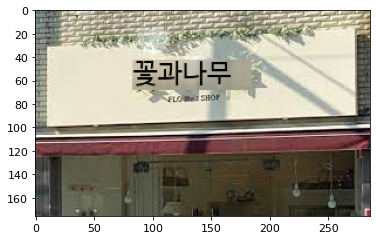

In [ ]:
img_path = '/content/test/5.jpg'
img = cv2.imread(img_path)
crop_images, bboxs = yolov5s_detect(img)

texts = []
for crop_image in crop_images:
    sr_img = sr(crop_image)
    text = itt(sr_img)
    texts.append(text)

img_t = img_blur_text(image=img, bboxs=bboxs, texts=texts)

print(texts)
plt.imshow(img_t)


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10xmrzFfeRjVUWGS9onsuDkLrrRylrhLw
To: /content/best.pt
100% 14.8M/14.8M [00:00<00:00, 212MB/s]


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-7-1 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


탐지된 이미지의 수 :  2


Downloading...
From: https://drive.google.com/uc?id=17IK1YuODQxjJDQtVEqOF22EtvDh37wUs
To: /content/NanumBarunGothic.ttf
100%|██████████| 4.19M/4.19M [00:00<00:00, 210MB/s]

[['사진관'], ['여기에']]


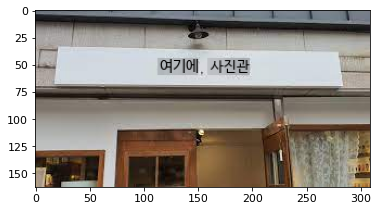

In [ ]:
img_path = '/content/test/1.jpg'
img = cv2.imread(img_path)
crop_images, bboxs = yolov5s_detect(img)

texts = []
for crop_image in crop_images:
    sr_img = sr(crop_image)
    text = itt(sr_img)
    texts.append(text)

img_t = img_blur_text(image=img, bboxs=bboxs, texts=texts)

print(texts)
plt.imshow(img_t)
